In [29]:
import numpy as np
import statsmodels.api as sm
from tqdm import tqdm
import matplotlib.pyplot as plt
import multiprocessing
from scipy import integrate
import pandas as pd
import ray
import numpy as np

In [30]:
samples = np.load('../../../../data/commaai/predictions/mdn/cpl/samples.npy').reshape(-1,1000)

In [31]:
# read in val data
density_path = '../../../../data/commaai/density/gaussian_density_filtered.csv'
density = pd.read_csv(density_path)

In [32]:
no_points = 750
grid = np.linspace(min(density['axes']), max(density['axes']), int(no_points))

In [20]:
densities = []
supports = []
for i in tqdm(range(0, samples.shape[0])):
    kde = sm.nonparametric.KDEUnivariate(samples[i,:])
    kde.fit() # Estimate the densities
    support = kde.support
    endog = kde.endog
    density = kde.density
    supports.append(support)
    densities.append(density) 

100%|██████████| 10472/10472 [00:15<00:00, 690.88it/s]


In [21]:
density_ext_list = []
density_ext = np.array(np.repeat(0, 750), dtype=float)
for j in tqdm(range(0, len(densities))):
    density_ext = np.array(np.repeat(0, 750), dtype=float)
    for i in range(0, supports[j].shape[0]):
        density_ext[np.where(np.abs(grid - supports[j][i]) == min(np.abs(grid - supports[j][i])))] = densities[j][i]
    density_ext_list.append(density_ext)

100%|██████████| 10472/10472 [21:52<00:00,  7.98it/s]


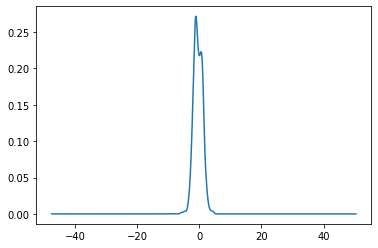

In [28]:
plt.plot(grid, density_ext_list[101])

In [24]:
density_ext_list = np.array(density_ext_list)
np.save('../../../../data/commaai/predictions/density_dropout_mdn.npy', density_ext_list)

In [33]:
density_ext_list = np.load('../../../../data/commaai/predictions/density_dropout_mdn.npy')

In [34]:
j = 0
cdf_mdn = [] 
for supp in tqdm(density_ext_list):
    dens = density_ext_list[j,:]
    def f_integral(i):
        return(integrate.trapz(dens[i:(i+2)], grid[i:(i+2)]))
    with multiprocessing.Pool(20) as proc:
        probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
    cdf_i = np.cumsum(np.array(probs))
    cdf_mdn.append(cdf_i)
    j += 1

100%|██████████| 10472/10472 [1:39:39<00:00,  1.75it/s] 


In [35]:
np.save('../../../../data/commaai/predictions/cdf_is_mdn.npy', np.array(cdf_mdn))

In [37]:
cdf_mdn[0].shape

(750,)